# CAMELS Multifield Dataset

In this project you will analyse simulated datasets from the Cosmology and Astrophysics with MachinE Learning Simulations (CAMELS) Multifield Dataset, CMD, to attempt to determine the fundamental parameters of the universe.

The CAMELS CMD simualted dataset is enormous so in this project we will only be using one small corner of the simulated data. You can find more details on the overall [CAMELS Multifield Dataset in their paper on arxiv](https://arxiv.org/abs/2109.10915).


## Cosmological parameters

Each map in the dataset comes from a simulation which is controlled by six parameters. Two of these are interesting cosmological parameters that we want to determine, whilst the other four parameters are effective parameters that we are less interested in but might need to consider to determine the interesting cosmological parameters.

| Variable      | Description |
| ----------- | ----------- |
| $\Omega_m$      | This is a cosmological parameter that represents the fraction of matter in the Universe.   |
| $\sigma_8$      | his is a cosmological parameter that controls the smoothness of the distribution of matter in the Universe  |
| $A_{SN1}$ & $A_{SN2}$     | These are two astrophysical parameters that controls two properties of supernova feedback  |
| $A_{AGN1}$ & $A_{AGN2}$     | These are two astrophysical parameters that control two properties of black-hole feedback|

## Types of 2D-Map

The simulated datasets are for a large number of astrophysical fields including

| Field   | Prefix   |
| ----------- | ---- |
| Gas density     | Mgas |
| Gas velocity    | Vgas |
| Gas temperature | T |
| Gas metallicity    | Z |
| Neutral hydrogen density    | HI |
| Electron number density    | ne |
| Magnetic fields   | B |
| Magnesium over Iron   | MgFe |
| Dark matter density  | Mcdm |
| Dark matter velocity  | Vcdm |
| Stellar mass density | Mstar |  
| Total matter density | Mtot |

There are several different types of datasets avalible deriving from different simulations and with different ways of varying the astrophysical parameters. In this miniproject we will confine ourselves to look only at the IllustrisTNG simulation where a single astrophysical parameter is varied at a time.

## Machine learning tasks

1. Train a machine learning algorithm to predict the cosmological parameters from a single map
2. Train a machine learning algorithm to predict the cosmological parameters from multiple maps (e.g. of different fields at the same time)

## Potential extensions

1. Train a machine learning algortithm on one field and use it to predict the cosmological parameters on other fields
2. Train a generative algorithm that is able to take a map of one field and produce a map of another, are there particular fields that are good or bad at predicting other fields?

## Things to remember
In the '1P' dataset that we have downloaded a single parameter is varied at a time. For each set of parameters there are 15 images. So 66 parameter combinations result in 990 images of each field.

Questions:
* What type of data preprocessing will be needed?
* How will you split the data in to train, validation and test samples?



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  #Needed for plotting things on log scale

In [2]:
# import the urllib library
import urllib.request
import os

labelFile='params_1P_IllustrisTNG.txt'
firstFile='Maps_B_IllustrisTNG_1P_z=0.00.npy'

def getFile(fileName):
    # Copy a network object to a local file
    urllib.request.urlretrieve('https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/'+fileName, fileName)

if not os.path.isfile(firstFile):
    getFile(firstFile)

if not os.path.isfile(labelFile):
    getFile(labelFile)

params.shape (66, 6)
bMap.shape (990, 256, 256)
Maps per paramater line 15
Maxiumum Value 2.011384e-06
Minimum Value 1.8111102e-15


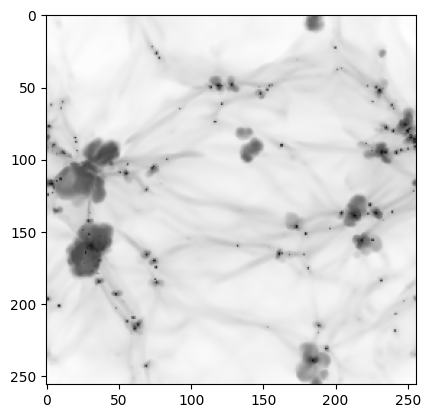

In [3]:
params=np.loadtxt(labelFile)
bMap=np.load(firstFile)
print("params.shape",params.shape)
print("bMap.shape",bMap.shape)
print("Maps per paramater line",bMap.shape[0]//params.shape[0])
print("Maxiumum Value",np.max(bMap[0]))
print("Minimum Value",np.min(bMap[0]))

fig, ax = plt.subplots()
ax.imshow(np.log10(bMap[0]),cmap="binary")


In [4]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.layers import BatchNormalization, Activation, Dropout
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten

# Task 1 : Only training on Bmap

We will split the train-valid-test as 9:3:3 maps. After this we will augment the data so we have 4 times the initial data, with various reflections performed on each map. Labels will be split accordingly.

In [5]:
#Splitting Maps into sets
#intialising sets so dimensions do not clash with np.concatenate
train_data = bMap[0:9,:,:]
valid_data = bMap[9:12,:,:]
test_data = bMap[12:15,:,:]
n = 2
while n < 67:

    train_data = np.append(train_data,bMap[((n-1)*15):((n*15)-6),:,:], axis = 0)
    valid_data = np.append(valid_data, bMap[((n*15)-6):((n*15)-3),:,:], axis = 0)
    test_data = np.append(test_data , bMap[((n*15)-3):((n)*15),:,:], axis = 0)
    n += 1

#Augmenting Data
#Possible Augmentions include: 3 reverse
train_augment_1 = tf.reverse(train_data,[0])
train_augment_2 = tf.reverse(train_data,[1])
train_augment_3 = tf.reverse(train_data,[2])
train_data = np.concatenate((train_data,train_augment_1, train_augment_2, train_augment_3), axis = 0)

#Splitting Labels into sets
#Initialising arrays
train_labels_values = []
test_valid_labels_values = []
for i in params: #Repeating parameters for each map
    train_labels_values.append([i]*9)
    test_valid_labels_values.append([i]*3)

#To make data and labels have same dimensions.
train_labels = np.concatenate(train_labels_values, axis = 0)
for i in range(2):
  train_labels = np.append(train_labels, train_labels, axis = 0)
test_valid_labels = np.concatenate(test_valid_labels_values, axis = 0)

In [6]:
#Creating Netwrok Architecture
#Convolutions & pooling
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(96, (8, 8), strides = (3,3), activation='relu', padding = "valid", input_shape=(256, 256, 1)))
model.add(keras.layers.MaxPool2D((3,3), strides = (2,2)))
model.add(keras.layers.Conv2D(256, (3, 3), strides = (2,2), padding = "same", activation='relu'))
model.add(keras.layers.MaxPool2D((3,3), strides = (2,2)))
model.add(keras.layers.Conv2D(384, (3,3), strides = (1,1), padding = "same", activation='relu'))
model.add(keras.layers.MaxPool2D((3,3), strides = (2,2)))
model.add(keras.layers.Conv2D(96, (3,3), strides = (1,1), padding = "same", activation='relu'))
#Dense Layers
model.add(keras.layers.Flatten())
model.add(Dropout(0.7)) #Dropout
model.add(keras.layers.Dense(6))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 83, 83, 96)        6240      
                                                                 
 max_pooling2d (MaxPooling2  (None, 41, 41, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 256)       221440    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 384)       885120    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 384)         0

In [7]:
#intialising values
epochs = 10
learning_rate = 1e-2
sgd = keras.optimizers.SGD(learning_rate = learning_rate, momentum=0.9) #setting SGD hyperparameters
#compile with loss metric
model.compile(optimizer=sgd,
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
#fit model
history = model.fit(train_data, train_labels, epochs=epochs, batch_size=32, validation_data=(valid_data, test_valid_labels))

Epoch 1/10
75/75 [==============================] - 27s 348ms/step - loss: 0.2197 - mean_squared_error: 0.2197 - val_loss: 0.0992 - val_mean_squared_error: 0.0992
Epoch 2/10
75/75 [==============================] - 26s 342ms/step - loss: 0.1082 - mean_squared_error: 0.1082 - val_loss: 0.0996 - val_mean_squared_error: 0.0996
Epoch 3/10
75/75 [==============================] - 26s 341ms/step - loss: 0.1060 - mean_squared_error: 0.1060 - val_loss: 0.0987 - val_mean_squared_error: 0.0987
Epoch 4/10
75/75 [==============================] - 25s 338ms/step - loss: 0.1039 - mean_squared_error: 0.1039 - val_loss: 0.0994 - val_mean_squared_error: 0.0994
Epoch 5/10
75/75 [==============================] - 28s 370ms/step - loss: 0.1050 - mean_squared_error: 0.1050 - val_loss: 0.0986 - val_mean_squared_error: 0.0986
Epoch 6/10
75/75 [==============================] - 26s 340ms/step - loss: 0.1023 - mean_squared_error: 0.1023 - val_loss: 0.0989 - val_mean_squared_error: 0.0989
Epoch 7/10
75/75 [====

7/7 [==============================] - 1s 81ms/step - loss: 0.0981 - mean_squared_error: 0.0981


[0.09813804179430008, 0.09813804179430008]

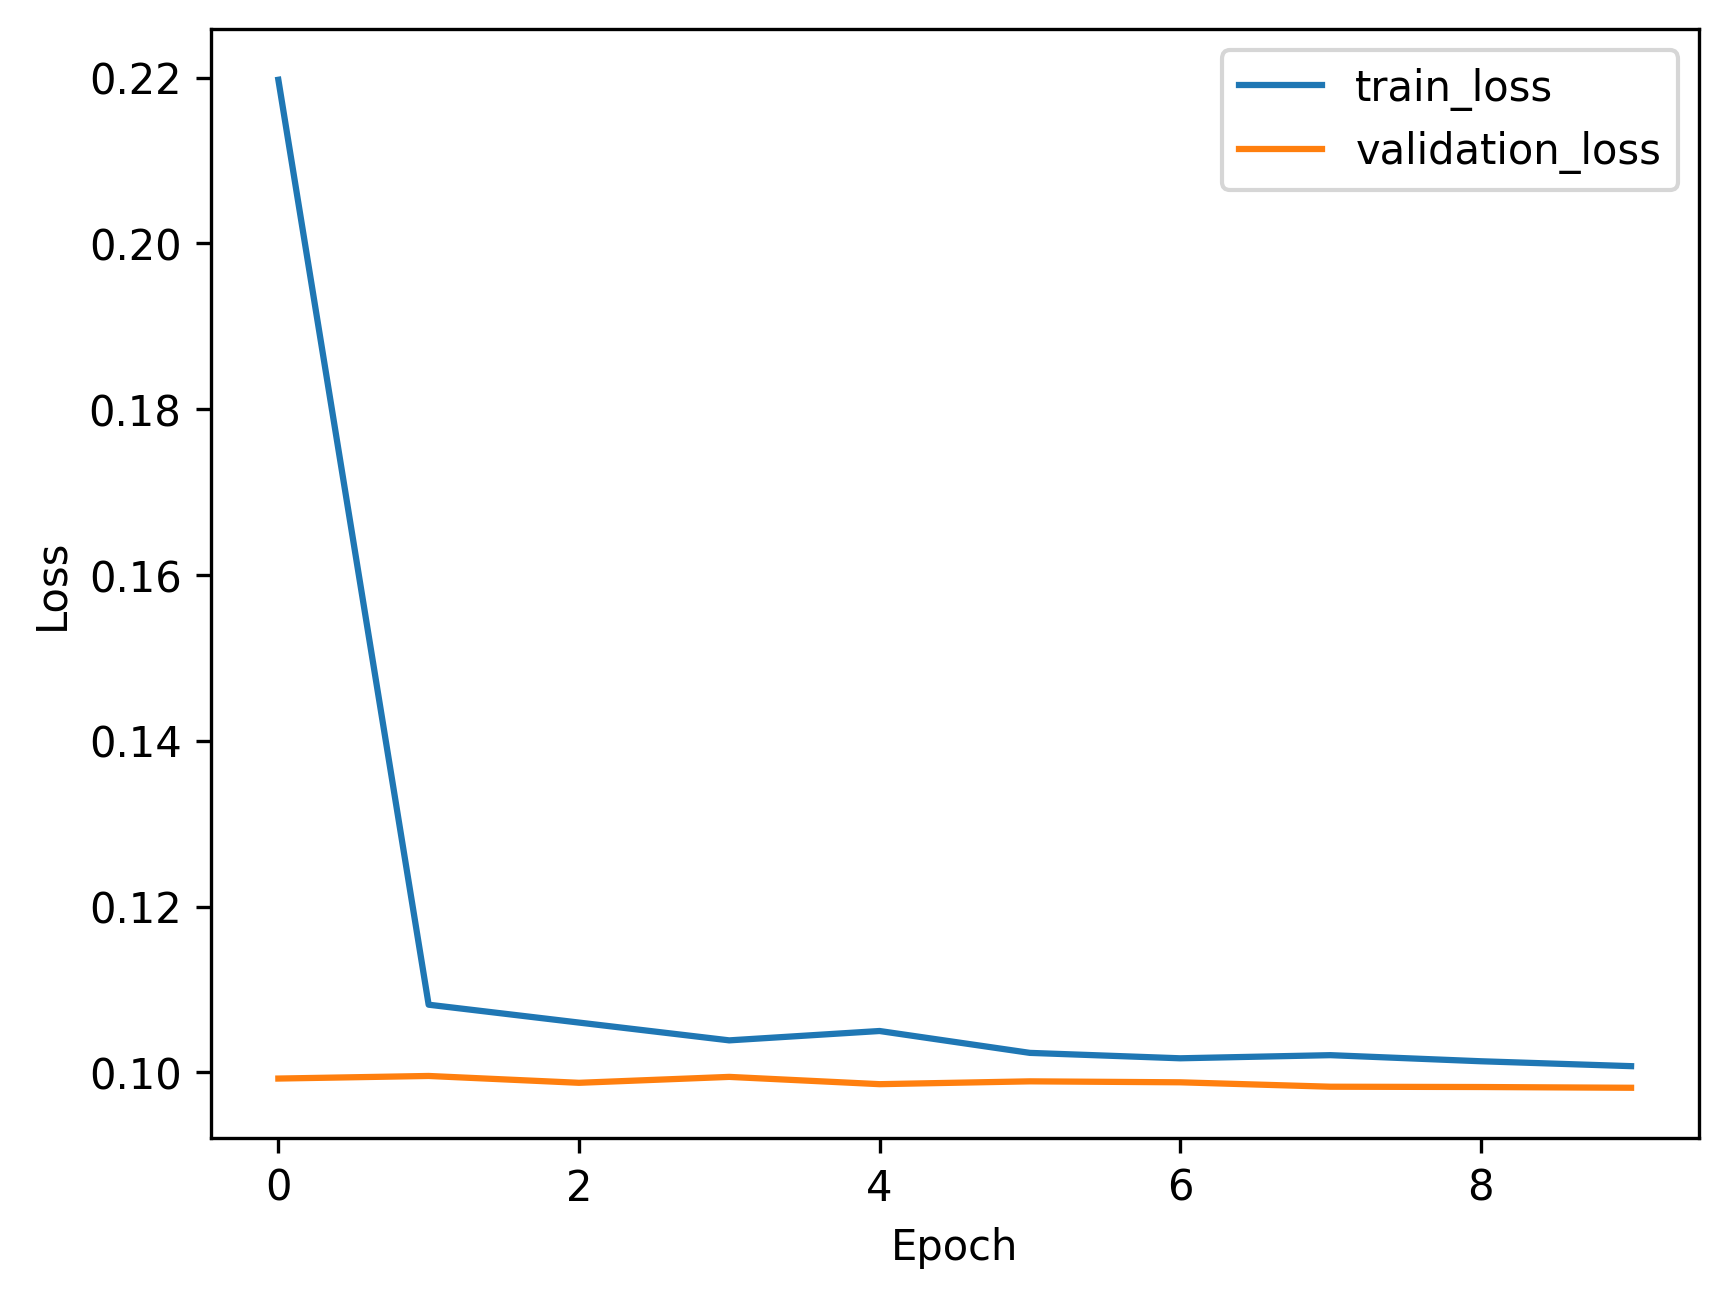

In [16]:
#Plot training and validation loss
plt.figure(dpi = 300)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#Print test loss
model.evaluate(test_data, test_valid_labels ,batch_size=32)

As can be seen, train loss and validation loss are very close. As validation loss is lower than train loss we know this must be a well-trained model. By testing we know the higher value of the training loss is due to dropout. If dropout was removed both losses converge to ~0.098.

# Task 2: Training on all Maps

To make the code efficient, we will use dictionaries to create all data. We will create a 'maps' array with the identifier for all fields, and using this array to perform loading the file and perform train-valid-test split.

In [8]:
maps = ['Mgas', 'Vgas', 'T', 'Z', 'HI', 'ne', 'B', 'MgFe', 'Mcdm', 'Vcdm', 'Mstar', 'Mtot']
file_names = [] #Maps_{element}_IllustrisTNG_1P_z=0.00.npy'
file = [] #'{element}_file'
map_var = [] #{element}_map

#Thir loop creates an array of the actual file names, as well as the file variable
for element in maps:
    file_names.append(f'Maps_{element}_IllustrisTNG_1P_z=0.00.npy')
    file.append(f'{element}_file')
    map_var.append(f'{element}_map')
# Creating variables and assigning values from file_names
for var_name, file_name in zip(file, file_names):
    exec(f"{var_name} = '{file_name}'")
#Loading file into map dictionary
for file_var, map_var_name in zip(file, map_var):
    file_name = globals()[file_var]
    if not os.path.isfile(file_name):
        getFile(file_name)
    globals()[map_var_name] = np.load(file_name)
del(file_names, file)

In [9]:
#creating train, valid, and test arrays
train_maps = []
valid_maps = []
test_maps = []
#creating individual train, valid, test arrays for each map
for element in maps:
  train_maps.append(f'{element}_train')
  valid_maps.append(f'{element}_valid')
  test_maps.append(f'{element}_test')
for train, valid, test, map_var_name in zip(train_maps, valid_maps, test_maps, map_var):
  globals()[train] = globals()[map_var_name][0:9,:,:]
  globals()[valid] = globals()[map_var_name][9:12,:,:]
  globals()[test] = globals()[map_var_name][12:15,:,:]
  n = 2
  while n < 67:
    globals()[train] = np.append(globals()[train],globals()[map_var_name][((n-1)*15):((n*15)-6),:,:], axis = 0)
    globals()[valid] = np.append(globals()[valid], globals()[map_var_name][((n*15)-6):((n*15)-3),:,:], axis = 0)
    globals()[test] = np.append(globals()[test] , globals()[map_var_name][((n*15)-3):((n)*15),:,:], axis = 0)
    n += 1
#Append all maps' train, valid, and test arrays to form dataset
new_train = globals()[train_maps[0]]
for i in range(len((train_maps)) - 1):
  new_train = np.append(new_train, globals()[train_maps[i+1]],axis = 0)

new_valid = globals()[valid_maps[0]]
for i in range(len((valid_maps))-1):
  new_valid = np.append(new_valid, globals()[valid_maps[i+1]],axis = 0)

new_test = globals()[test_maps[0]]
for i in range(len((test_maps))-1):
  new_test = np.append(new_test, globals()[test_maps[i+1]],axis = 0)
#deleting variable to help RAM
del(train_maps, valid_maps, test_maps)
#Augmenting Data
#Possible Augmentions include: 3 reverse
new_train_augment_1 = tf.reverse(new_train,[0])
new_train_augment_2 = tf.reverse(new_train,[1])
new_train_augment_3 = tf.reverse(new_train,[2])
new_train = np.concatenate((new_train,new_train_augment_1, new_train_augment_2, new_train_augment_3) ,axis = 0) #Concatenating all data to form augmented dataset
#deleting variable to help RAM
del(new_train_augment_1, new_train_augment_2, new_train_augment_3,n)

In [10]:
#creating label placeholder arrays
new_train_labels_values = []
new_test_valid_labels_values = []

r = 0
while r < 4*12: # 4 for each augment, 12 for each map
    for i in params: #Repeating parameters for each map
      new_train_labels_values.append([i]*9)
    r += 1
#concatenating arrays to create label dataset
new_train_label = np.concatenate(new_train_labels_values, axis = 0)
del(new_train_labels_values, r)
print(np.shape(new_train_label))
s=0
while s < 12:
  for i in params: #Repeating parameters for each map
    new_test_valid_labels_values.append([i]*3)
  s += 1
#To make data and labels have same dimensions.
new_test_valid_label = np.concatenate(new_test_valid_labels_values, axis = 0)
del(new_test_valid_labels_values, s)

(28512, 6)


In [11]:
#creating model
#convolution layers, pool layers, and batchnorm
model_2 = keras.models.Sequential()
model_2.add(keras.layers.Conv2D(96, (8, 8), strides = (3,3), activation='relu', padding = "valid", input_shape=(256, 256, 1)))
model_2.add(BatchNormalization())
model_2.add(keras.layers.MaxPool2D((3,3), strides = (2,2)))
model_2.add(keras.layers.Conv2D(256, (3, 3), strides = (2,2), padding = "same", activation='relu'))
model_2.add(BatchNormalization())
model_2.add(keras.layers.MaxPool2D((3,3), strides = (2,2)))
model_2.add(keras.layers.Conv2D(256, (3,3), strides = (1,1), padding = "same", activation='relu'))
model_2.add(BatchNormalization())
model_2.add(keras.layers.MaxPool2D((3,3), strides = (2,2)))
model_2.add(keras.layers.Conv2D(96, (3,3), strides = (1,1), padding = "same", activation='relu'))
model_2.add(BatchNormalization())
model_2.add(keras.layers.Flatten())
#dense layers
model_2.add(keras.layers.Dense(6))
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 83, 83, 96)        6240      
                                                                 
 batch_normalization (Batch  (None, 83, 83, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 41, 41, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 256)       221440    
                                                                 
 batch_normalization_1 (Bat  (None, 21, 21, 256)       1024      
 chNormalization)                                                
                                                      

In [12]:
#setting up hyperparamters for model
epochs = 60
learning_rate = 2e-4
adam = keras.optimizers.Adam(learning_rate=2e-4)
#compile
model_2.compile(optimizer=adam,
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
#train model
history_2 = model_2.fit(new_train, new_train_label, epochs=epochs, batch_size=256, validation_data=(new_valid, new_test_valid_label))

Epoch 1/60
112/112 [==============================] - 389s 3s/step - loss: 0.3083 - mean_squared_error: 0.3083 - val_loss: 1.8796 - val_mean_squared_error: 1.8796
Epoch 2/60
112/112 [==============================] - 386s 3s/step - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.6732 - val_mean_squared_error: 0.6732
Epoch 3/60
112/112 [==============================] - 390s 3s/step - loss: 0.1137 - mean_squared_error: 0.1137 - val_loss: 0.4893 - val_mean_squared_error: 0.4893
Epoch 4/60
112/112 [==============================] - 379s 3s/step - loss: 0.1097 - mean_squared_error: 0.1097 - val_loss: 0.3547 - val_mean_squared_error: 0.3547
Epoch 5/60
112/112 [==============================] - 367s 3s/step - loss: 0.1065 - mean_squared_error: 0.1065 - val_loss: 0.3274 - val_mean_squared_error: 0.3274
Epoch 6/60
112/112 [==============================] - 393s 4s/step - loss: 0.1042 - mean_squared_error: 0.1042 - val_loss: 0.3273 - val_mean_squared_error: 0.3273
Epoch 7/60
112/112 [==

10/10 [==============================] - 8s 792ms/step - loss: 0.1115 - mean_squared_error: 0.1115


[0.11153023689985275, 0.11153023689985275]

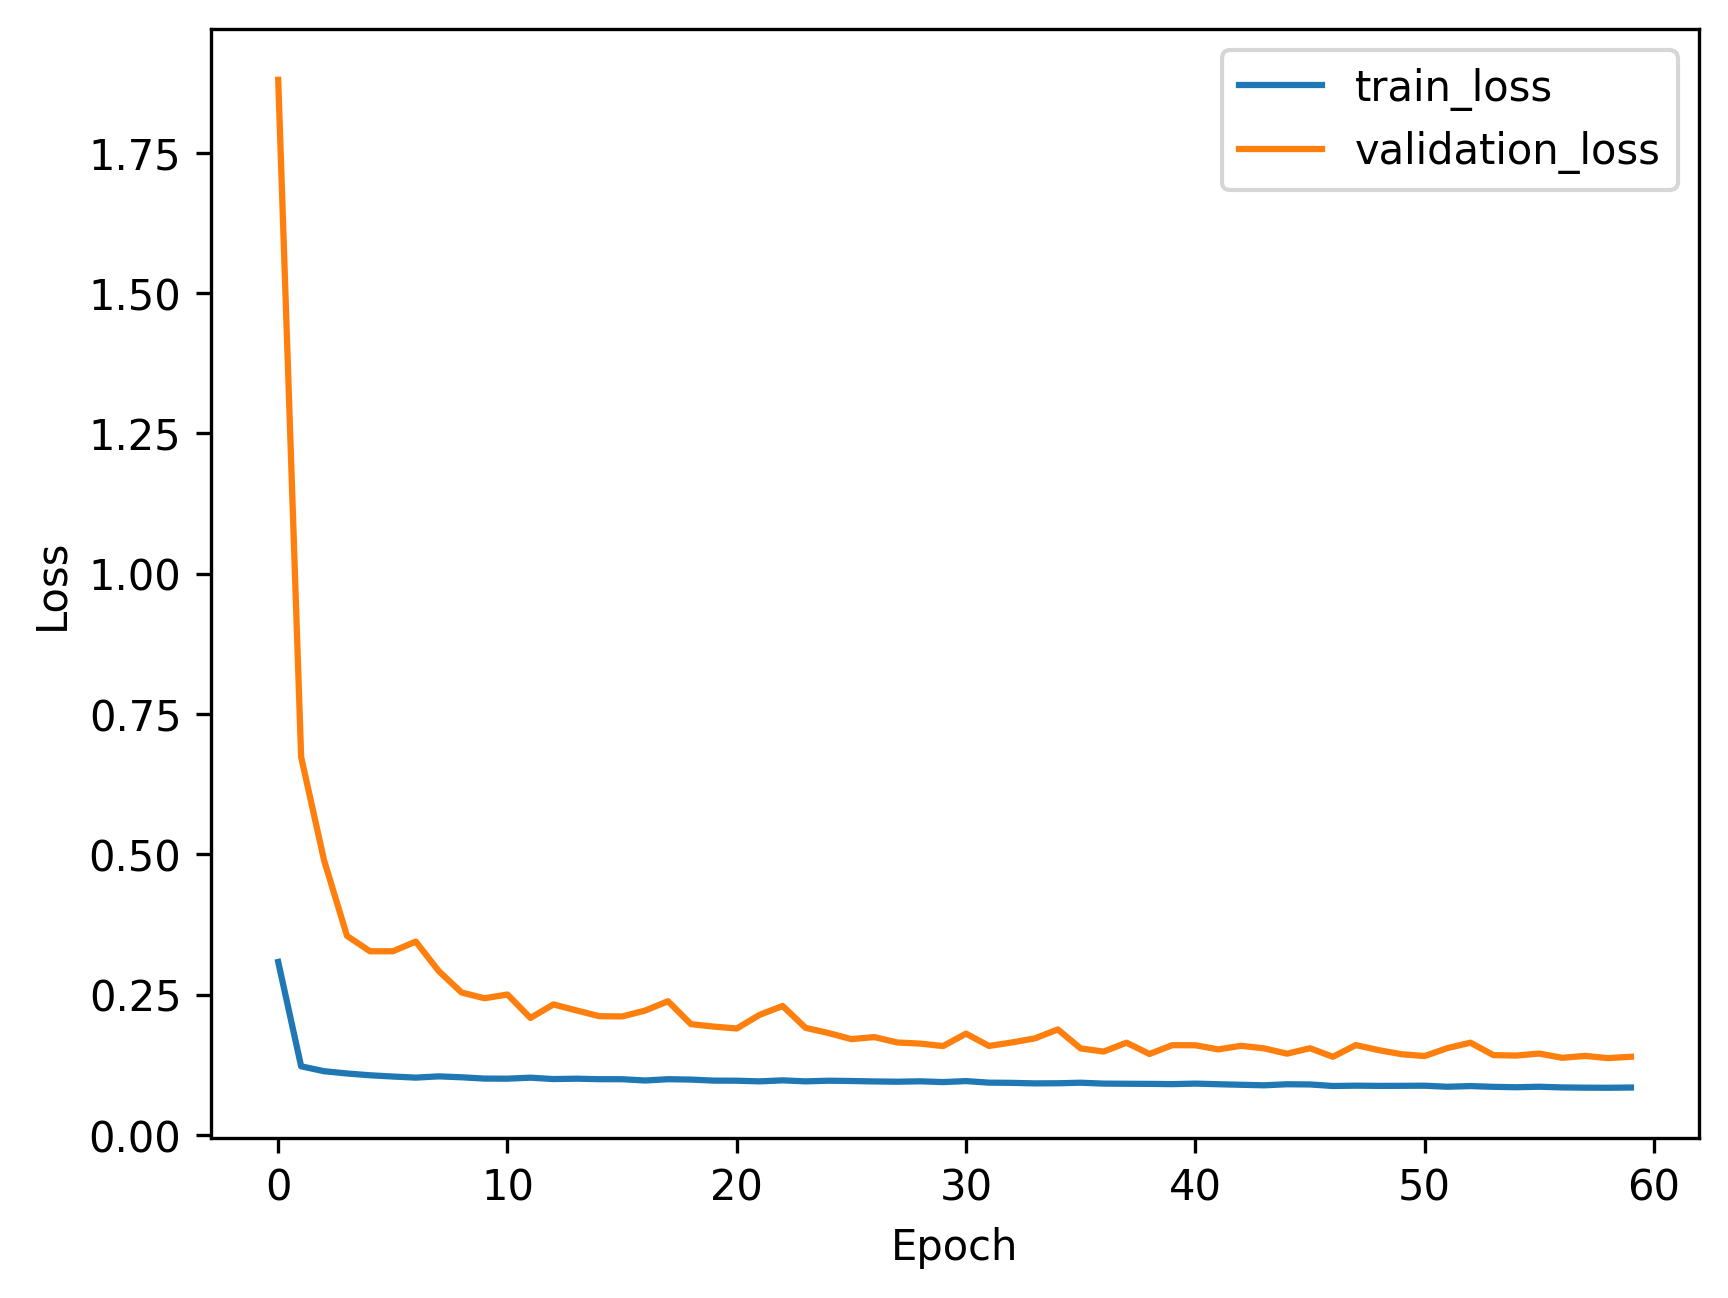

In [17]:
#Plot training and validation loss
plt.figure(dpi = 300)
plt.plot(history_2.history['loss'], label='train_loss')
plt.plot(history_2.history['val_loss'], label = 'validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#Print test error
model_2.evaluate(new_test, new_test_valid_label ,batch_size=256)

model_2 performs worse than model, however it is clear via the plot that the validation loss is still close to the training loss and the model has been well trained.